#### HS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
from Mandelbrot_h import whenLeaveMandelbrotSet as wlms
from Mandelbrot import inMandelbrotSet as ims
from MonteCarloIntegration import orthogonalSampling as OS

escape_time()

In [ ]:
# Computing the escape time j
def escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh):
    sqr = int(np.floor(np.sqrt(s_num)))
    if sqr % 2 != 0:
        sqr += 1
    s_num = sqr**2
    col_boundings = np.linspace(xlow, xhigh, sqr + 1)
    row_boundings = np.linspace(ylow, yhigh, sqr + 1)
    js_up = np.zeros((int(sqr / 2), sqr))
    for i in range(int(sqr / 2)):
        for j in range(sqr):
            real = (col_boundings[j] + col_boundings[j + 1]) / 2
            imag = (row_boundings[i] + row_boundings[i + 1]) / 2
            c = complex(real, imag)
            js_up[i, j] = wlms(c, iter_num)
    js_low = js_up[::-1]
    js = np.vstack((js_up, js_low))

    return js

Escape time heatmap

In [ ]:
iter_num = 100
s_num = int(1e6)
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5
sqr = int(np.floor(np.sqrt(s_num)))
s_num = sqr**2
js = escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh)

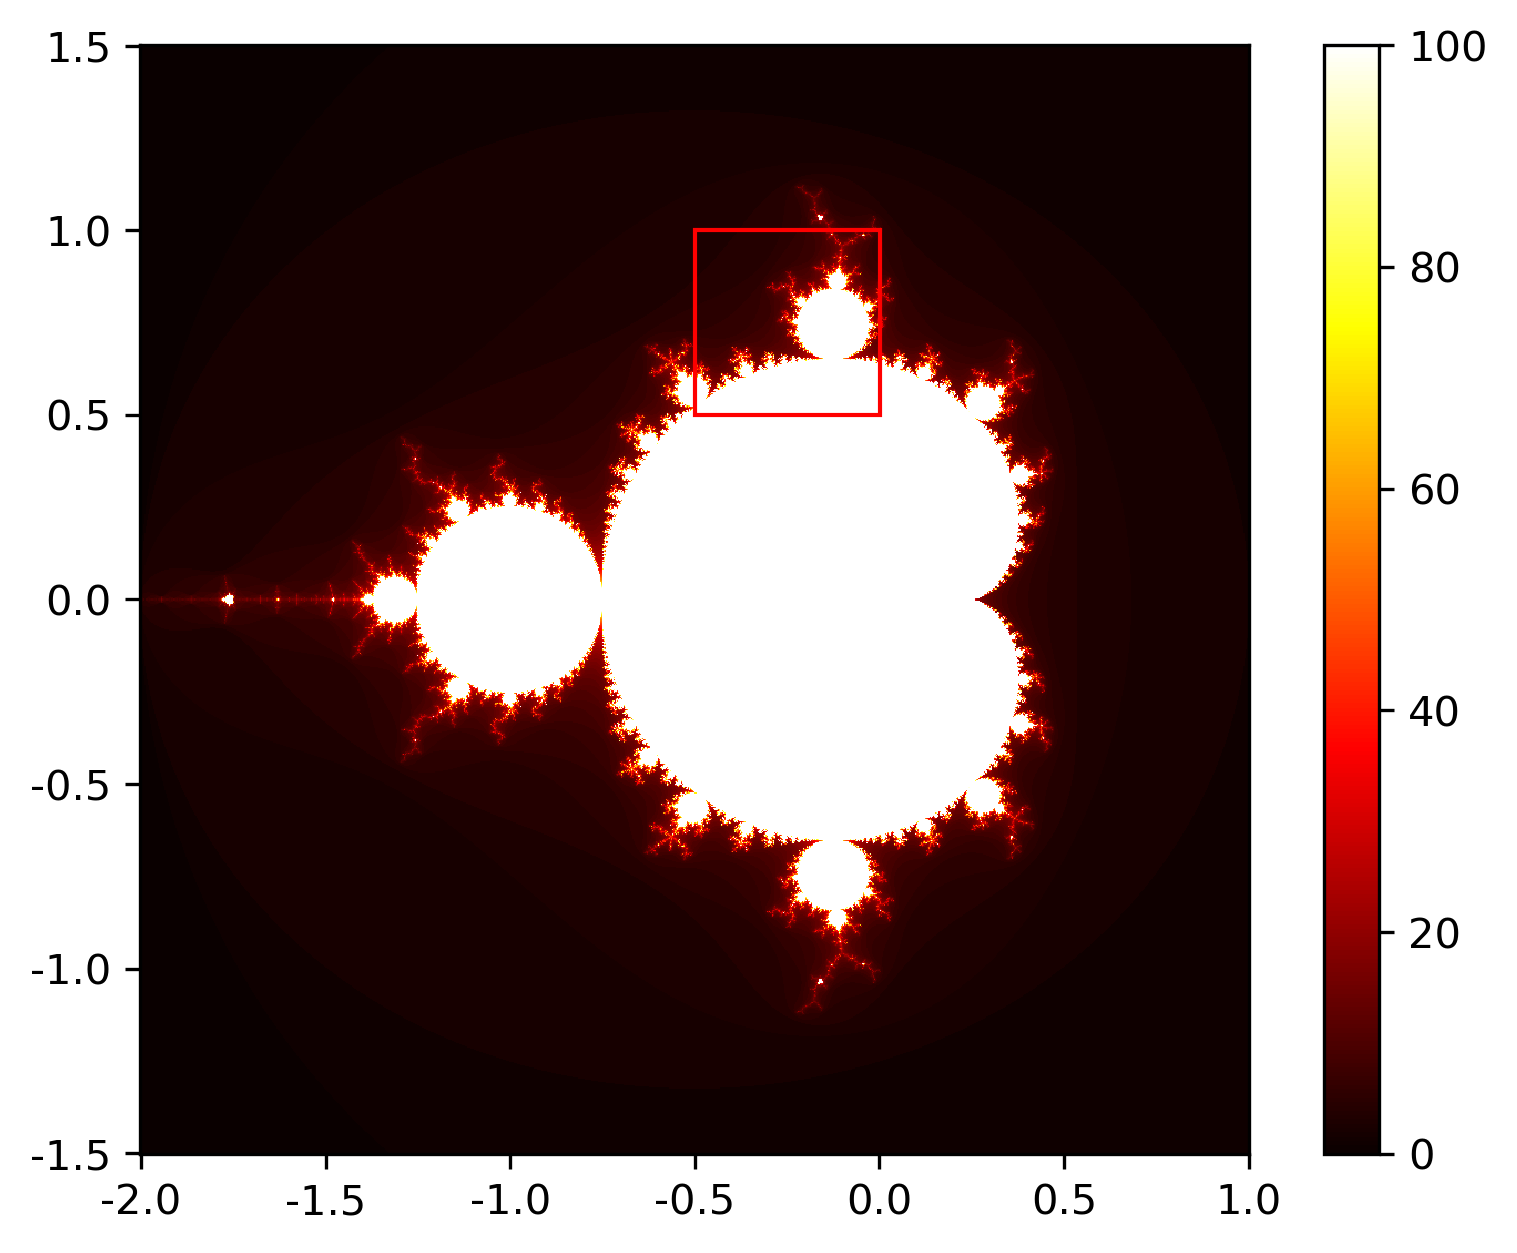

In [ ]:
# Global heatmap
fig, ax = plt.subplots(dpi=300)
im1 = ax.imshow(js, cmap='hot', interpolation='nearest')
old_xticks = np.linspace(0, sqr - 1, 7)
old_yticks = np.linspace(sqr - 1, 0, 7)
new_xticks = np.linspace(xlow, xhigh, 7)
new_yticks = np.linspace(ylow, yhigh, 7)
ax.set_xticks(old_xticks, new_xticks)
ax.set_yticks(old_yticks, new_yticks)
rect = plt.Rectangle((sqr / 2, sqr / 6),
                     sqr / 6,
                     sqr / 6,
                     fill=False,
                     edgecolor='red',
                     linewidth=1)
ax.add_patch(rect)
plt.colorbar(im1)
plt.show()

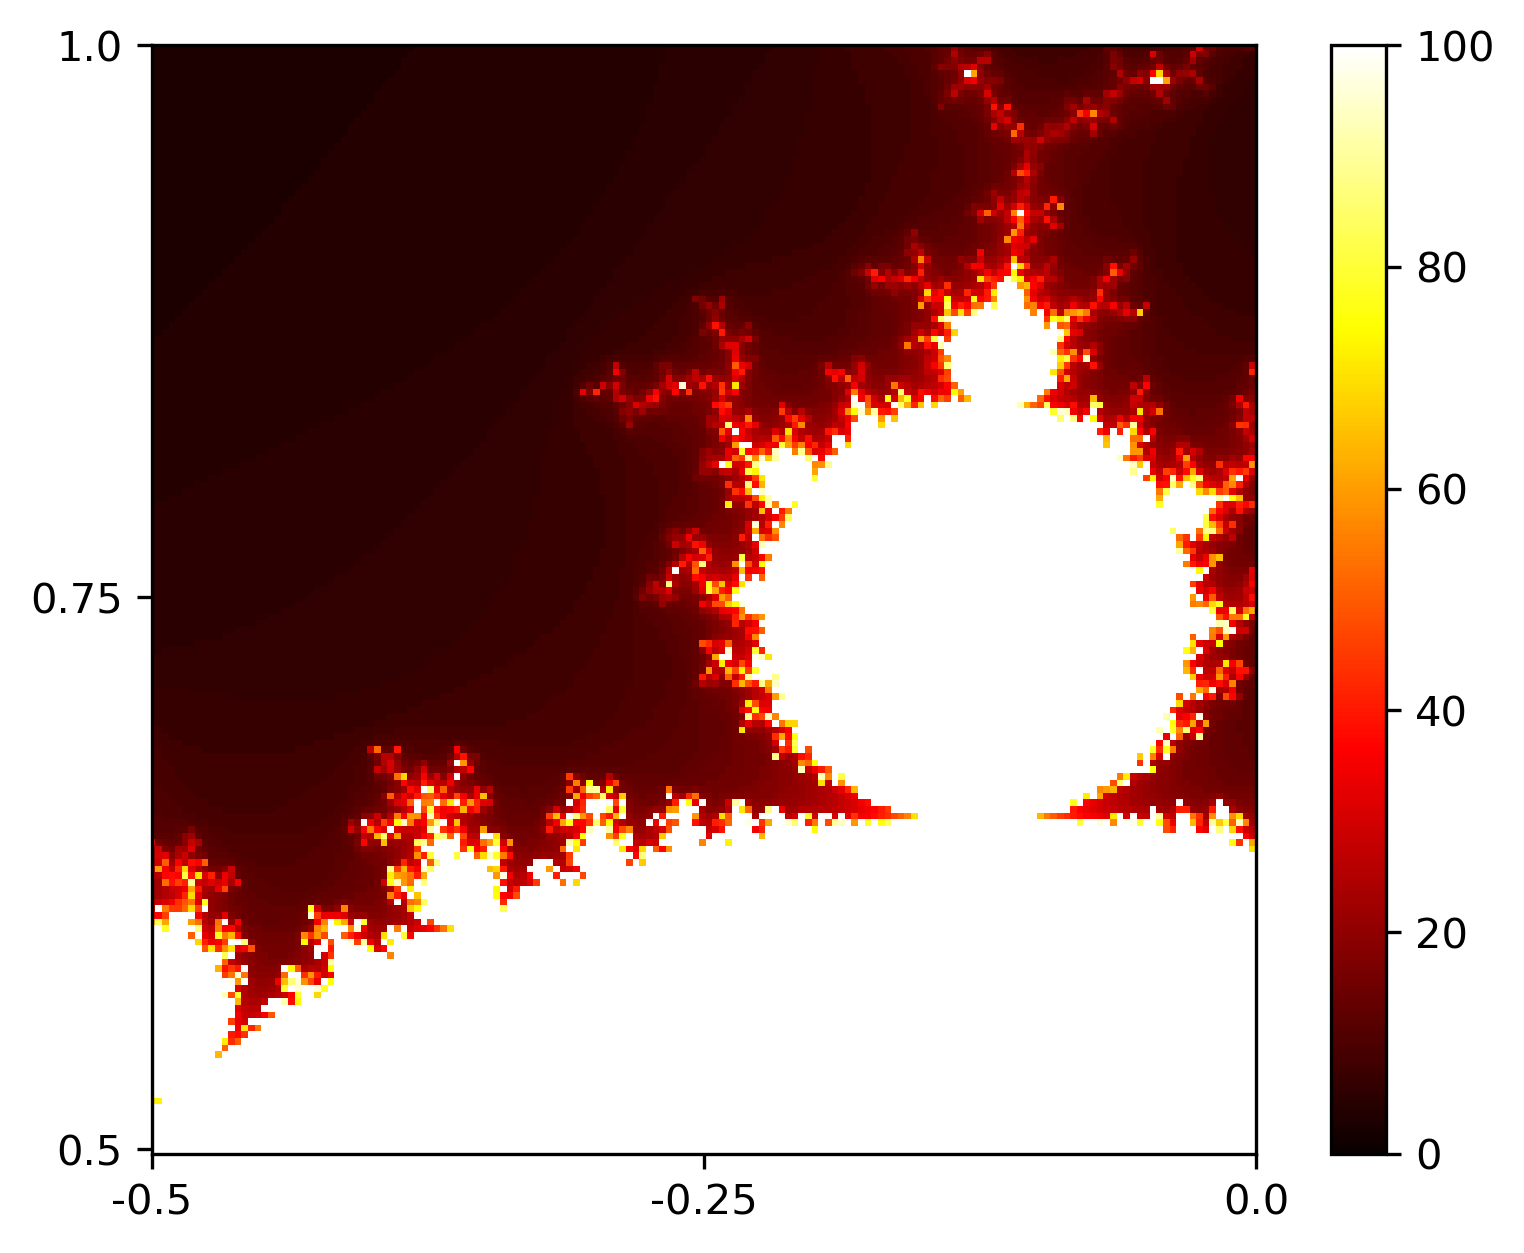

In [ ]:
# Local heatmap
plt.figure(dpi=300)
plt.imshow(js, cmap='hot', interpolation='nearest')
plt.xlim(int(sqr / 2), int(sqr / 2 + sqr / 6))
plt.ylim(int(4 / 6 * sqr), int(5 / 6 * sqr))
old_xticks = np.linspace(sqr / 2, sqr / 2 + sqr / 6, 3)
old_yticks = np.linspace(4 / 6 * sqr, 5 / 6 * sqr, 3)
new_xticks = np.linspace(-0.5, 0, 3)
new_yticks = np.linspace(0.5, 1, 3)
plt.xticks(old_xticks, new_xticks)
plt.yticks(old_yticks, new_yticks)
plt.colorbar()
plt.show()

get_edge()

In [ ]:
def get_edge(js, iter_num, s_num, xlow, xhigh, ylow, yhigh, threshold=20):
    '''Get the edges of Mandelbrot set.
    Parameters:
        js: Escape time of all the grids
        iter_num: Number of iterations
        s_num: Number of samples
        xlow, xhigh, ylow, yhigh: The boundings of the sampling region
    Returns:
        edge_matrix: A boolean matrix, 1 means on the edge
        edge_rows, edge_cols: Sparse representation of the actual position
    '''
    sqr = int(np.floor(np.sqrt(s_num)))
    s_num = sqr**2
    cond = (js > threshold) & (js < iter_num)
    edge_matrix = np.zeros_like(cond)
    rows, cols = np.where(cond)
    for row, col in zip(rows, cols):
        edge_matrix[row - 1:row + 2, col - 1:col + 2] = 1
    rows, cols = np.where(edge_matrix)
    edge_rows = np.linspace(ylow, yhigh, sqr + 1)[rows]
    edge_cols = np.linspace(xlow, xhigh, sqr + 1)[cols]

    return edge_matrix, edge_rows, edge_cols

In [ ]:
row = 1
col = 1
boolm = np.array([[0,0,0],[0,1,0],[0,0,0]])
boolm[row-1:row+2, col-1:col+2] = 1
print(boolm)

[[1 1 1]
 [1 1 1]
 [1 1 1]]


Time cost of edge discovery

In [ ]:
%%timeit
iter_num = 100
s_num = int(1e6)
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5
sqr = int(np.floor(np.sqrt(s_num)))
js = escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh)
edge_matrix, _, _ = get_edge(js, iter_num, s_num, xlow, xhigh, ylow, yhigh)


956 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Show the edge

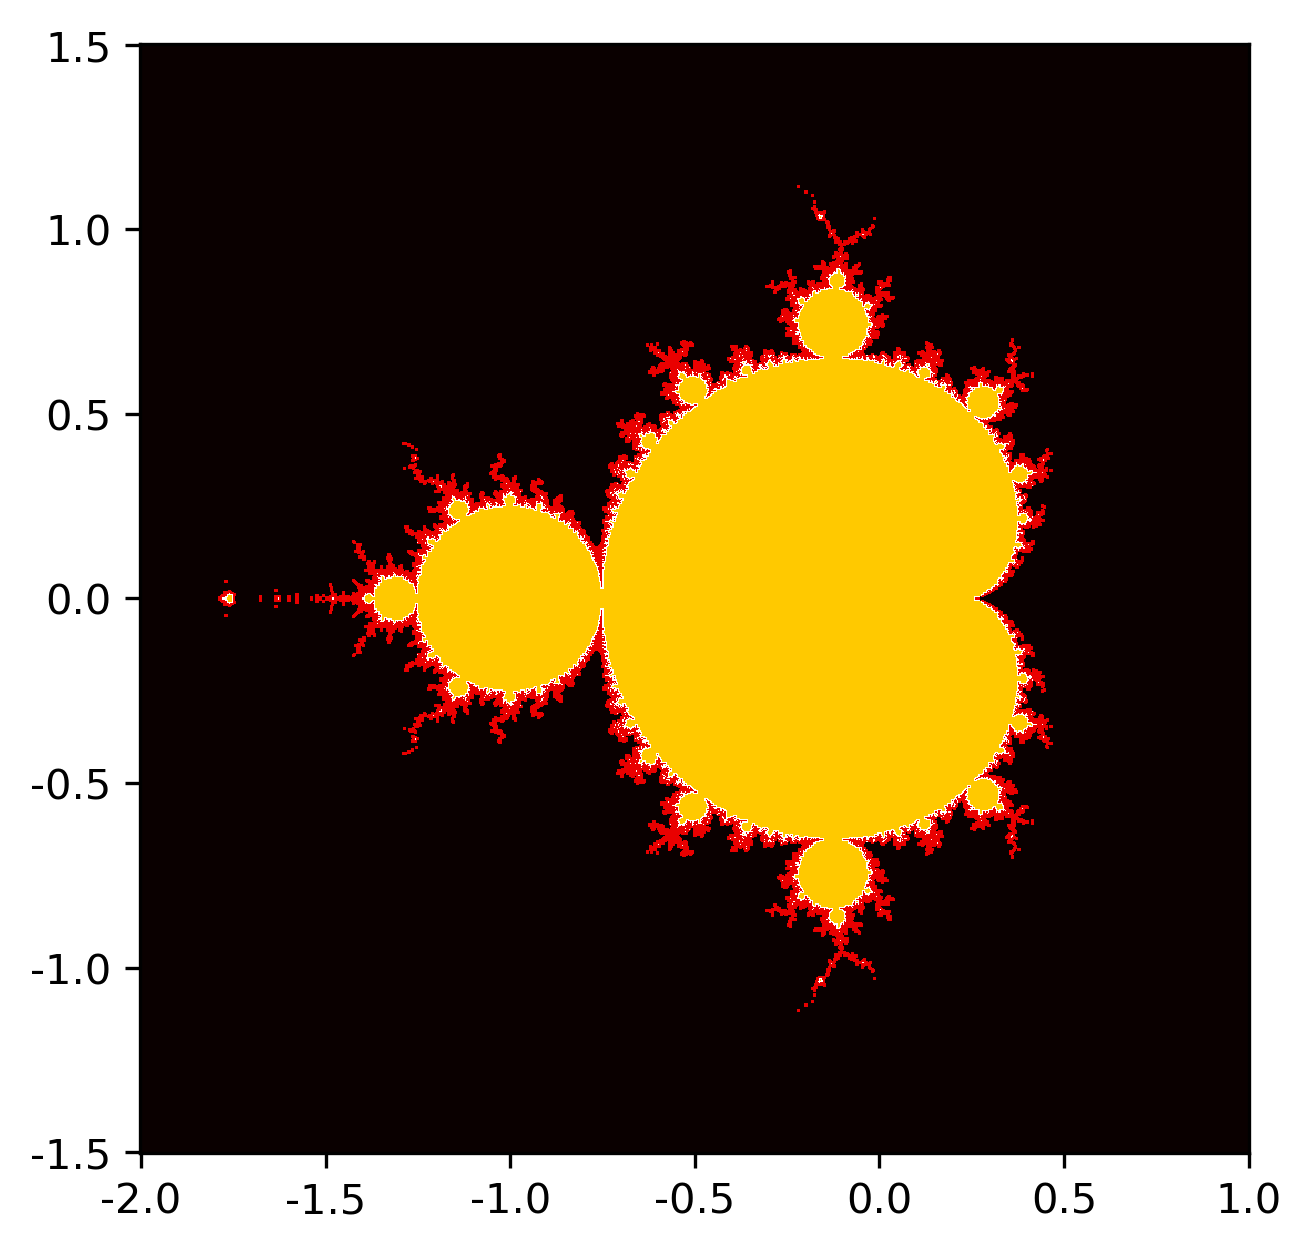

In [ ]:
iter_num = 100
s_num = int(1e6)
xlow, xhigh = -2, 1
ylow, yhigh = -1.5, 1.5
sqr = int(np.floor(np.sqrt(s_num)))
js = escape_time(iter_num, s_num, xlow, xhigh, ylow, yhigh)
edge_matrix, _, _ = get_edge(js, iter_num, s_num, xlow, xhigh, ylow, yhigh)

within_region = (js == iter_num)
regions = np.zeros_like(js)
regions += edge_matrix + 2 * within_region

# Show the edge
fig, ax = plt.subplots(dpi=300)
im = ax.imshow(regions, cmap='hot', interpolation='nearest')
old_xticks = np.linspace(0, sqr - 1, 7)
old_yticks = np.linspace(sqr - 1, 0, 7)
new_xticks = np.linspace(xlow, xhigh, 7)
new_yticks = np.linspace(ylow, yhigh, 7)
ax.set_xticks(old_xticks, new_xticks)
ax.set_yticks(old_yticks, new_yticks)

plt.show()

In [ ]:
def heuristicSampling(iter_num, s_find_edge, s_num, xmin, xmax, ymin, ymax):
    grid_sqr = int(np.floor(np.sqrt(s_find_edge)))
    s_find_edge = grid_sqr**2
    js = escape_time(iter_num, s_find_edge, xmin, xmax, ymin, ymax)
    edge_matrix, edge_rows, edge_cols = get_edge(js,
                                                 iter_num,
                                                 s_find_edge,
                                                 xmin,
                                                 xmax,
                                                 ymin,
                                                 ymax)
    within_region = (js == iter_num)
    regions = np.zeros_like(js)
    regions += edge_matrix + 2 * within_region
    within_region = (js == iter_num)
    regions = np.zeros_like(js)
    # Let within region = 2, on edge = 1, within becomes edge = 3
    regions += edge_matrix + 2 * within_region
    within_region = regions == 2
    A_total = (xmax - xmin) * (ymax - ymin)
    A_within = A_total * np.sum(within_region) / s_find_edge
    # Compute A_edge
    grid_width = (xmax - xmin) / grid_sqr
    grid_height = (ymax - ymin) / grid_sqr
    grid_area = grid_width * grid_height
    # We have used some samples to find the edge
    s_num -= s_find_edge
    edge_grid_num = len(edge_rows)
    edge_grid_area = edge_grid_num * grid_area
    s_per_grid = int(np.floor(s_num / edge_grid_num))
    # Compute how many samples on the edge are in the M set
    N_edge = 0
    for row, col in zip(edge_rows, edge_cols):
        for s in range(s_per_grid):
            imag = np.random.uniform(row, row + grid_height)
            real = np.random.uniform(col, col + grid_width)
            c = complex(real, imag)
            N_edge += ims(c=c, iterations=iter_num)
    A_edge = N_edge / (s_per_grid * edge_grid_num) * edge_grid_area

    return A_within + A_edge

Constant s, varying i

In [ ]:
# constant s, varying i
i_s = range(100, 1100, 100)
s_find_edge = int(1e4)
s_num = int(1e5)
mean_OS, mean_HS = [], []
std_OS, std_HS = [], []
for i in i_s:
    As_OS, As_HS = [], []
    for j in range(20):
        As_OS.append(OS(-2, 2, i, s_num))
        As_HS.append(heuristicSampling(i, s_find_edge, s_num, -2, 2, -2, 2))
    mean_OS.append(np.mean(As_OS))
    mean_HS.append(np.mean(As_HS))
    std_OS.append(np.std(As_OS))
    std_HS.append(np.std(As_HS))

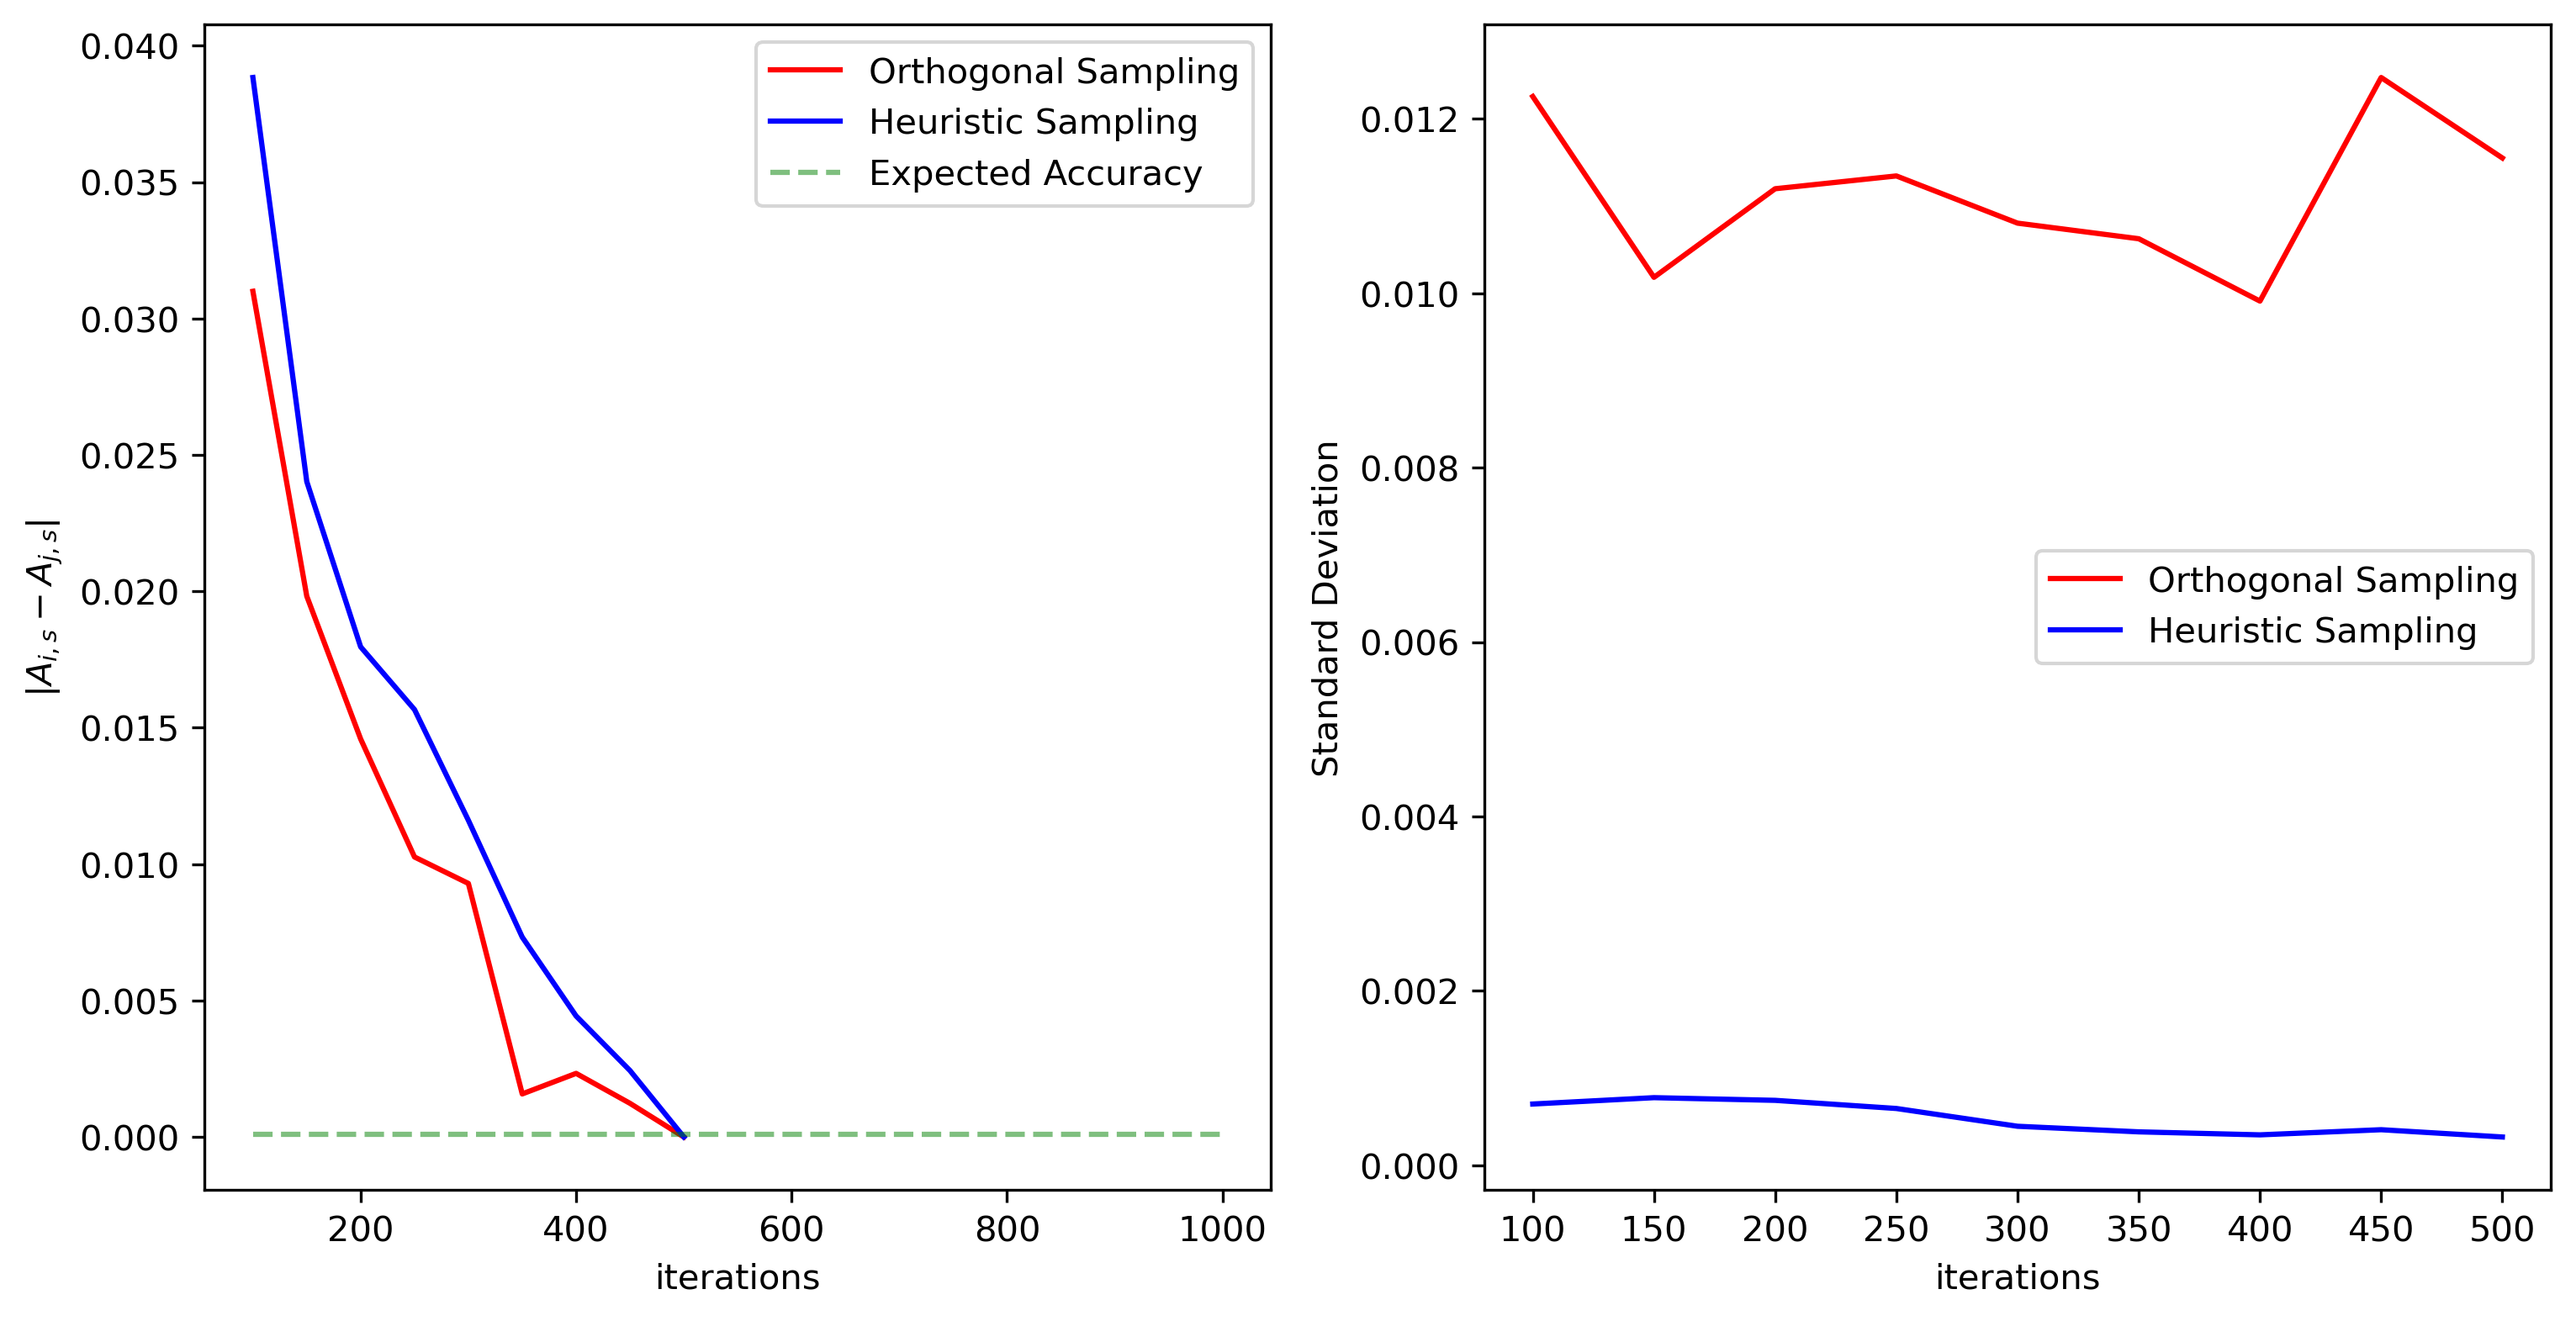

In [ ]:
# Prepare
mean_OS = np.array(mean_OS)
mean_HS = np.array(mean_HS)
std_OS = np.array(std_OS)
std_HS = np.array(std_HS)
deltaA_OS = np.abs(mean_OS-mean_OS[-1])
deltaA_HS = np.abs(mean_HS-mean_HS[-1])

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
axes[0].set_xlabel("iterations")
axes[0].set_ylabel("$|A_{i,s}-A_{j,s}|$")
axes[0].plot(i_s, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(i_s, deltaA_HS, label='Heuristic Sampling', c='b')
axes[0].hlines(expected_accuracy, 100, 1000, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
axes[0].legend()
axes[1].set_xlabel("iterations")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(i_s, std_OS, label='Orthogonal Sampling', c='r')
axes[1].plot(i_s, std_HS, label='Heuristic Sampling', c='b')
axes[1].legend()
plt.show()

In [ ]:
print(mean_OS[-1])
print(mean_HS[-1])

1.6324661810613943
1.6243080124869926


Constant i, varying s

In [ ]:
# constant i, varying s
i = 50
s_num = range(2000, 3100, 100)
s_find_edge = 1000
mean_OS, mean_HS = [], []
std_OS, std_HS = [], []
for s in s_num:
    As_OS, As_HS = [], []
    for j in range(50):
        As_OS.append(OS(-2, 2, i, s))
        As_HS.append(heuristicSampling(i, s_find_edge, s, -2, 2, -2, 2))
    mean_OS.append(np.mean(As_OS))
    mean_HS.append(np.mean(As_HS))
    std_OS.append(np.std(As_OS))
    std_HS.append(np.std(As_HS))

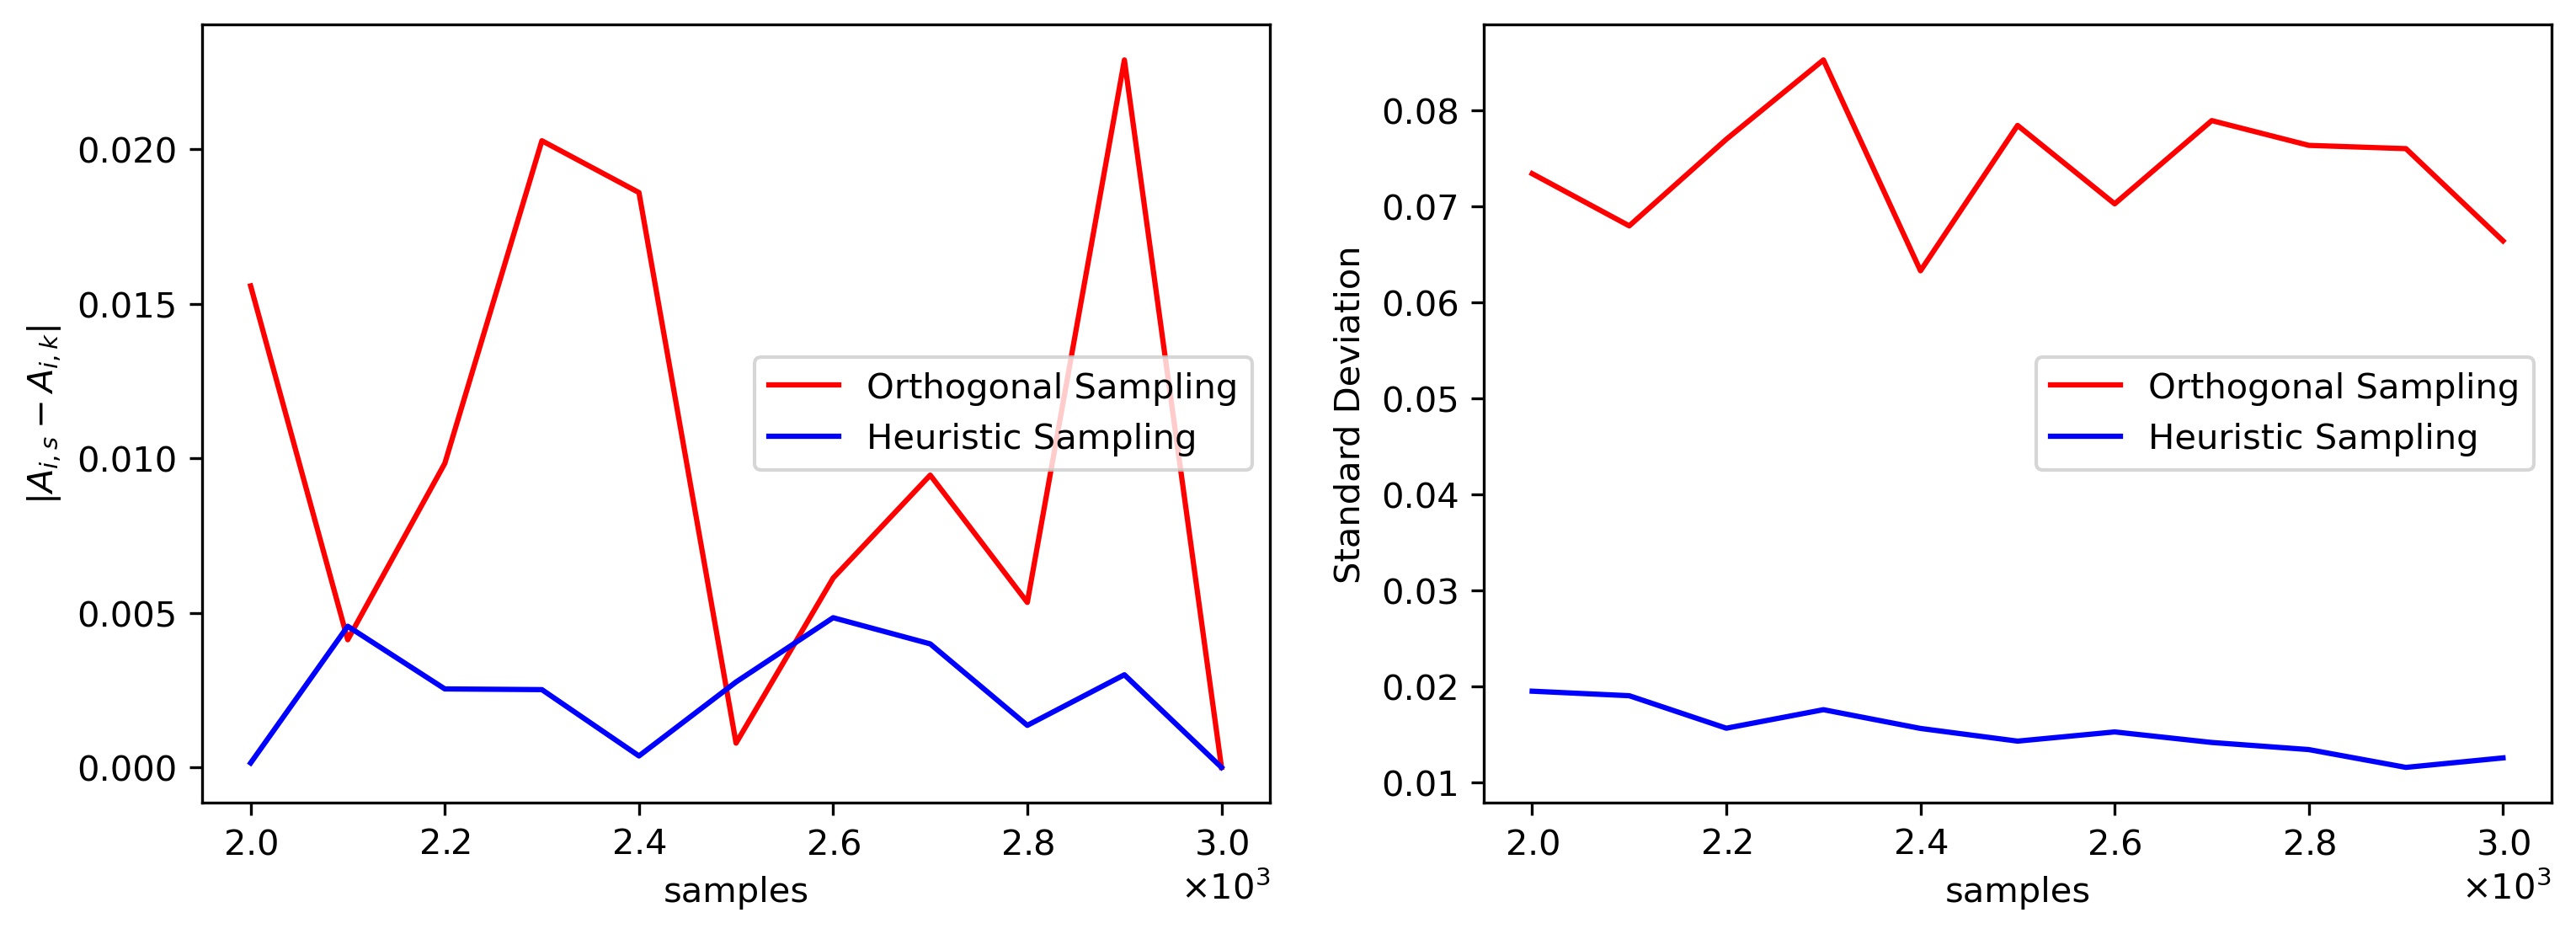

In [ ]:
# Plot
mean_OS = np.array(mean_OS)
mean_HS = np.array(mean_HS)
std_OS = np.array(std_OS)
std_HS = np.array(std_HS)
deltaA_OS = np.abs(mean_OS-mean_OS[-1])
deltaA_HS = np.abs(mean_HS-mean_HS[-1])
expected_accuracy = 1e-4

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
axes[0].set_xlabel("samples")
axes[0].set_ylabel("$|A_{i,s}-A_{i,k}|$")
axes[0].plot(s_num, deltaA_OS, label='Orthogonal Sampling', c='r')
axes[0].plot(s_num, deltaA_HS, label='Heuristic Sampling', c='b')
# axes[0].hlines(expected_accuracy, 100, 1000, linestyle='dashed', color="green", alpha=0.5, label='Expected Accuracy')
axes[0].legend()
axes[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].set_xlabel("samples")
axes[1].set_ylabel("Standard Deviation")
axes[1].plot(s_num, std_OS, label='Orthogonal Sampling', c='r')
axes[1].plot(s_num, std_HS, label='Heuristic Sampling', c='b')
axes[1].legend()
axes[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()